In [1]:
import networkx as nx 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import optimize
import scipy
import sys
import pandas as pd


from src import SingleAgent as sa
from src import helperfunctions as hf
from src import MonteCarloIsing as mci

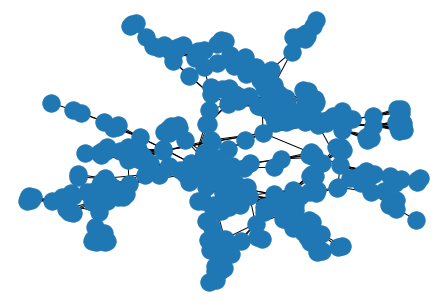

In [2]:
path = 'C:/Users/zuzan/OneDrive/Dokumenty/Master-Papers/real_networks/ca-netscience.txt'


df = pd.read_csv(path, delimiter = " ")

def extract_network(df):

    G = nx.from_pandas_edgelist(df,source='FromNodeId', target='ToNodeId')
    subgraphs=[G.subgraph(c) for c in nx.connected_components(G)]
    subgraphs_sizes = sorted([len(subgraph.nodes) for subgraph in subgraphs])
    
    mapping = {i:k for k,i in enumerate(list(G.nodes))}
    H=nx.relabel_nodes(G,mapping)
    
    return H


G = extract_network(df)

nx.draw(G)



In [3]:
        

budget=40.0
h = np.zeros(len(G.nodes.keys()))

system = sa.mf_ising_system(G,h,iim_iter=1000,fixed_point_iter=int(5*1e2),step_size=0.01,init_mag='random')


beta_crit=hf.crit_b(system.adj_matrix)
beta = beta_crit
print(beta_crit)
control,final_mag=system.MF_IIM(budget,beta)


0.0963812815943178


In [ ]:
beta_min = 0.25*beta_crit 
beta_max = 5*beta_crit 
# needs a wide range of beta to visibly include constant average degree intervals

exp_beta_list = np.logspace(np.log10(beta_min),np.log10(beta_max),num=50,endpoint=False)



normal_params = {'graph':G,'background_field':h,
                         'iim_iter':10000,'iim_tol_fac':1e-6,'fixed_point_iter':5000,
                                'step_size':5.0,'optimiser_type':'sgdm','momentum':0.1,'init_mag':'random'}

iters=10
runs =np.zeros((iters,len(exp_beta_list),system.graph_size))

for run in range(runs.shape[0]):
    system = sa.mf_ising_system(**normal_params) 
    for i,beta in enumerate(exp_beta_list):
        control,_=system.MF_IIM(budget,beta)
        if i%10==0:
            print(i,beta)
        runs[run,i,:]=control

        
mean_run = np.mean(runs,axis=0)
var_run = np.var(runs,axis=0)
print('FINISHED')    


In [ ]:
invalid = {"graph", "background_field"}
def without_keys(d, keys):
    return {x: d[x] for x in d if x not in keys}

def params_name(params,invalid=invalid):
    params_string = [str(key)+str(entry) for key,entry in without_keys(params,invalid).items()]
    string='RealNet_Average_'+'_'.join(params_string)
    return string

params_name(normal_params)

In [ ]:
import matplotlib


def average_degree(G,control,budget):
    return np.sum([G.degree[i]*con for i,con in enumerate(control)])/budget



matplotlib.rcParams.update({'font.size': 14,'figure.figsize':(7,5),'axes.labelsize': 'large',
                           'axes.titlesize':18})


avs_degrees=np.zeros(len(exp_beta_list))
var_degrees = np.zeros(len(exp_beta_list))
for it,control in enumerate(mean_run):
    av_degree = average_degree(G,control,budget)
    avs_degrees[it]=av_degree
    variance_degree = np.sum([(G.degree[i]/budget)**2*var for i,var in enumerate(var_run[it])])
    var_degrees[it]=variance_degree

    
fig,ax = plt.subplots()

ax.plot(exp_beta_list,avs_degrees)
ax.set_xscale(value='log')

ax.set_xticks([0.03,0.05,0.1,0.25,0.5])

ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_ylabel('Average degree')
ax.vlines(beta_crit,ymin=min(avs_degrees),ymax=max(avs_degrees),linestyles='dashed',color='red',label=r'$\beta_{crit}$')
ax.fill_between(exp_beta_list, avs_degrees-np.sqrt(var_degrees), avs_degrees+np.sqrt(var_degrees),
                    **{'color':'green','alpha':0.5})


ax.set_xlabel(r'Interaction Strenght ($\beta$)')
ax.set_title('Distribution of influence \n'+ r'as a function of $\beta$')
ax.legend()
#string_name='RealNet_Average'+{}
# path = 'C:/Users/zuzan/OneDrive/Dokumenty/Master-Papers/Masters_figures/'


# plt.savefig(path+params_name(normal_params)+'.png'.format(*[normal_params[x] for x in ['step_size','fixed_point_iter','iim_iter']]))
# plt.show()


In [5]:
# class monte_carlo_simulations:
#     def __init__(self,graph,background_field):
#         self.graph = graph
#         self.graph_size = len(self.graph.nodes())
#         self.adj_matrix = nx.to_numpy_matrix(graph)
#         half_size = int(self.graph_size/2)
#         if self.graph_size%2==0:
#             spins = np.concatenate([np.ones(half_size),(-1)*np.ones(half_size)])
#         else:
#             spins = np.concatenate([np.ones(half_size+1),(-1)*np.ones(half_size)])
#         np.random.shuffle(spins)
#         self.init_spins = spins
#         self.background_field = background_field
   
b =np.zeros(len(G.nodes.keys()))

mc_system = mci.monte_carlo_simulations(G,b,T_burn=5000)



In [6]:
import matplotlib

matplotlib.rcParams.update({'font.size': 14,'figure.figsize':(7,5),'axes.labelsize': 'large',
                           'axes.titlesize':18})


normal_params = {'graph':G,'background_field':b,
                         'iim_iter':10000,'iim_tol_fac':1e-6,'fixed_point_iter':5000,
                                'step_size':5.0,'optimiser_type':'sgdm','momentum':0.1,'init_mag':'random'}

budgets = np.arange(0,200,10)
system = sa.mf_ising_system(**normal_params)

T = 5000
MC = 500




all_types_mean={'MF':[],'Central':[],'Random':[],'Degree':[]}
all_types_std={'MF':[],'Central':[],'Random':[],'Degree':[]}

for budget in budgets:
    print(budget)
    print('MF')
    mags=[]
    for i in range(10):
        system = sa.mf_ising_system(**normal_params) 
        control,final_mag=system.MF_IIM(budget,beta_crit)
        mag = np.sum(final_mag)
        mags.append(mag)

    all_types_mean['MF'].append(np.mean(mags))
    all_types_std['MF'].append(np.std(mags))

    
    print('Central')
    mag_c,std_c= mc_system.centrality(budget,T,MC,beta_crit)
    all_types_mean['Central'].append(mag_c)
    all_types_std['Central'].append(std_c)


    print('Degree')
    mag_d,std_d = mc_system.degree(budget,T,MC,beta_crit)
    all_types_mean['Degree'].append(mag_d)
    all_types_std['Degree'].append(std_d)


    print('Random')
    mag_r,std_r= mc_system.random_set(budget,T,MC,beta_crit)
    all_types_mean['Random'].append(mag_r)
    all_types_std['Random'].append(std_r)





0
MF
Central
Degree
Random
10
MF
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter
Central
Degree
Random
20
MF
Central
Degree
Random
30
MF
Central
Degree
Random
40
MF
Central
Degree
Random
50
MF
Central
Degree
Random
60
MF
Central
Degree
Random
70
MF
Central
Degree
Random
80
MF
Central
Degree
Random
90
MF
Central
Degree
Random
100
MF
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter
Central
Degree
Random
110
MF
Central
Degree
Random
120
MF
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter
Central
Degree
Random
130
MF
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter
Central
Degree
Random
140
MF
Central
Degree
Random
150
MF
Central
Degree
Random
160
MF


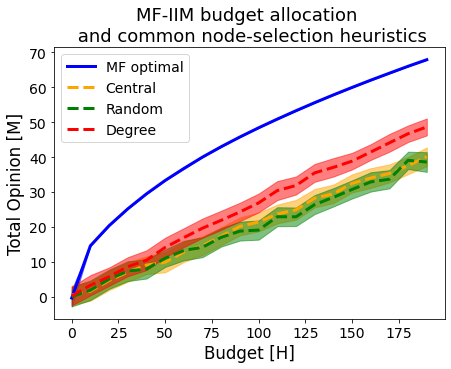

In [11]:
fig,ax=plt.subplots()
lw=3


ax.plot(budgets,all_types_mean['MF'],label='MF optimal',linewidth=lw,color='blue')
ax.fill_between(budgets, np.array(all_types_mean['MF'])-np.array(all_types_std['MF']),np.array(all_types_mean['MF'])+np.array(all_types_std['MF']),
                    **{'color':'blue','alpha':0.5})


ax.plot(budgets,all_types_mean['Central'],label='Central',linestyle='dashed',linewidth=lw,color='orange')
ax.fill_between(budgets, np.array(all_types_mean['Central'])-np.array(all_types_std['Central']),np.array(all_types_mean['Central'])+np.array(all_types_std['Central']),
                    **{'color':'orange','alpha':0.5})

ax.plot(budgets,all_types_mean['Random'],label='Random',linestyle='dashed',linewidth=lw,color='green')
ax.fill_between(budgets, np.array(all_types_mean['Random'])-np.array(all_types_std['Random']),np.array(all_types_mean['Random'])+np.array(all_types_std['Random']),
                    **{'color':'green','alpha':0.5})


ax.plot(budgets,all_types_mean['Degree'],label='Degree',linestyle='dashed',linewidth=lw,color='red')
ax.fill_between(budgets, np.array(all_types_mean['Degree'])-np.array(all_types_std['Degree']),np.array(all_types_mean['Degree'])+np.array(all_types_std['Degree']),
                    **{'color':'red','alpha':0.5})


ax.set_xlabel('Budget [H]')
ax.set_ylabel('Total Opinion [M]')
ax.set_title('MF-IIM budget allocation \n and common node-selection heuristics')
ax.legend()

path = 'C:/Users/zuzan/OneDrive/Dokumenty/Master-Papers/Masters_figures/'

plt.savefig(path+'final_real_network_comparison_16072021.png')
plt.show()

In [ ]:
system = mf_ising_system(G,h,iim_iter=1000,fixed_point_iter=5000,step_size=0.05)

degree(system,budget=12.0)

In [10]:
ratio=5.0

all_types_std['Central'] = np.array(all_types_std['Central'])/ratio
all_types_std['Degree'] = np.array(all_types_std['Degree'])/ratio
all_types_std['Random'] = np.array(all_types_std['Random'])/ratio

In [8]:
sc_mean=all_types_mean.copy()
sc_std = all_types_std.copy()